In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загружаем данные по оценкам

date_parser = lambda x: pd.datetime.strptime(x, "%d.%m.%Y %H:%M:%S")
rating_data = pd.read_csv('kaggle_data_01.csv', parse_dates=[1], date_parser=date_parser)

In [3]:
rating_data.head()

,person_id,date,Id,Prediction1
0,person_9,2017-06-02 10:03:36,1,3.0
1,person_9,2017-06-09 08:34:08,2,3.0
2,person_9,2017-06-16 10:19:03,3,3.0
3,person_9,2017-06-23 12:08:57,4,3.0
4,person_9,2017-06-30 12:48:39,5,4.0


In [4]:
# разделяем на известные оценки и те, которые надо предсказать

rating_known = rating_data[~rating_data['Prediction1'].isna()]
rating_unknown = rating_data[rating_data['Prediction1'].isna()]

persons = rating_data['person_id'].unique()
persons_known = rating_known['person_id'].unique()
persons_unknown = rating_unknown['person_id'].unique()

In [5]:
# Загружаем данные по фичам

date_parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
all_data = pd.read_csv('kaggle_data_02.csv', header=None, parse_dates=[1], date_parser=date_parser)
feature_labels = [x for x in np.arange(all_data.shape[1]-2)]
header = ['person_id', 'date'] + feature_labels
all_data.columns = header

In [6]:
all_data.head()

,person_id,date,0,1,2,3,4,5,6,7,...,456,457,458,459,460,461,462,463,464,465
0,person_1,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,person_1,2017-06-02,29.0,12.0,37.0,32.0,128.0,16.0,2.0,15.0,...,16.0,0.0,57.0,15.0,16.0,3.0,0.0,21.0,7.0,10.0
2,person_1,2017-06-03,10.0,4.0,10.0,8.0,34.0,4.0,1.0,4.0,...,4.0,0.0,11.0,4.0,4.0,1.0,2.0,19.0,6.0,6.0
3,person_1,2017-06-04,3.0,3.0,3.0,6.0,40.0,3.0,1.0,3.0,...,3.0,0.0,6.0,3.0,3.0,0.0,1.0,16.0,4.0,4.0
4,person_1,2017-06-05,4.0,3.0,12.0,11.0,62.0,4.0,1.0,4.0,...,4.0,0.0,17.0,4.0,4.0,2.0,2.0,20.0,6.0,7.0


---
### Работа с пропущенными значениями

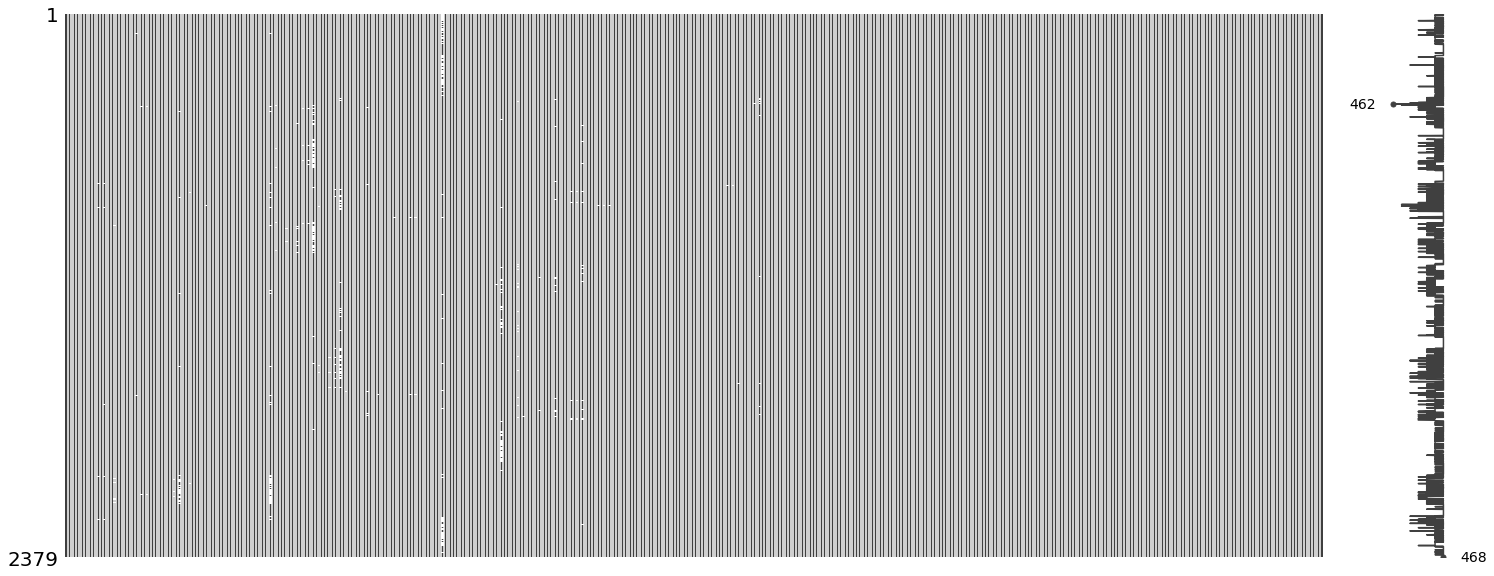

In [7]:
# Посмотрим в разрезе всех данных на пропуски

import missingno as msno

msno.matrix(all_data);

In [8]:
# Считаем пропущенные данные по столбцам

def missing_by_column(df, name):
    mis_val = df.isnull().sum().sort_values(ascending=False)
    mis_val = mis_val / df.shape[0] * 100
    mis_table = pd.DataFrame(round(mis_val, 1))
    mis_table = mis_table.rename(columns = {0 : name})
    mis_table = mis_table[mis_table[name] != 0]
    return mis_table.reset_index()

In [9]:
# Считаем пропущенные данные по строкам

def missing_by_row(df, name):
    mis_val = df.isnull().sum(axis=1).sort_values(ascending=False)
    mis_val = mis_val / df.shape[1] * 100
    mis_table = pd.DataFrame(round(mis_val, 1))
    mis_table = mis_table.rename(columns = {0 : name})
    mis_table = mis_table[mis_table[name] != 0]
    return mis_table.reset_index()

In [10]:
# Объединяем в одну таблицу проценты пропусков данных по фичам для каждого пользователя
# Возвращаем DataFrame с процентами пропусков выше заданного percent с разбивкой по фиче и пользователю

def missing_by_person(df, persons, percent):
    table = pd.DataFrame(data={'index': []})
    for person in persons:
        mis_table = missing_by_column(df[df['person_id'] == person], person)
        if not mis_table.empty:
            table = table.merge(mis_table, on='index', how='outer')
    table.set_index('index', inplace=True)
    table = table[table > percent].dropna(how='all').fillna(0)
    return table

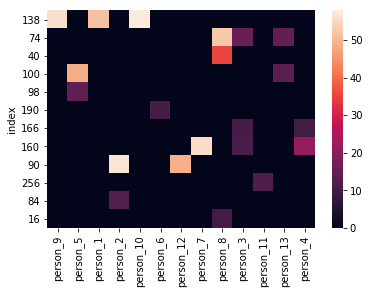

In [11]:
# Выделяем фичи, по которым больше всего пропусков для каждого пользователя.
# Может в дальнейшем вообще уберем их. Надо смотреть на вес конкретной фичи в результате.

# Пример, когда для пользователя по фиче пропущено больше 10%

sns.heatmap(missing_by_person(all_data, persons, 10))
plt.show()

In [12]:
# Удаляем пропуски в данных по заданному проценту пропусков
# percent - процент, выше которого удаляем
# num - количество пользователей, у которых процент выше заданного

def drop_missing_values(df, persons, percent=50, num=3, inplace=False):
    missing = missing_by_person(df, persons, percent)
    missing[missing > percent].count(axis=1)
    

In [13]:
# Заполняем пропуски в данных заданным значением
# kind - определяет, каким образом заполняем пропуски

def fill_missing_values(df, kind='mean', inplace=False):
    func = {'mean': np.mean, 'median': np.median}
    return df.fillna(func[kind](df), inplace=inplace)

---
### Работа с выборкой данных за заданный интервал времени

In [17]:
new_data = fill_missing_values(all_data)

In [23]:
missing = missing_by_person(all_data, persons, 50, 2)

In [32]:
(missing[missing > 50].count(axis=1) > 2)

index
138     True
74     False
160    False
90     False
dtype: bool

In [39]:
# Формируем матрицу признаков

In [ ]:
# 1. Копируем из фрейма оценок



In [ ]:
# Заполняем средним пустые поля

data_mean = all_data.fillna(all_data.mean())

In [19]:
# Смотрим, сколько незаполненных ячеек

all_data.isnull().sum()#.groupby(['person_id'])#.count()

person_id     0
date          0
p0            0
p1            0
p2            0
p3            0
p4            0
p5            0
p6            0
p7            0
p8            0
p9            0
p10          11
p11           0
p12          25
p13           0
p14           5
p15           0
p16          30
p17           0
p18           6
p19           0
p20           8
p21           0
p22           0
p23           0
p24           8
p25           0
p26           6
p27           0
             ..
p436          0
p437          0
p438          0
p439          0
p440          0
p441          0
p442          0
p443          0
p444          0
p445          0
p446          0
p447          0
p448          0
p449          0
p450          0
p451          0
p452          0
p453          0
p454          0
p455          0
p456          0
p457          0
p458          0
p459          0
p460          0
p461          0
p462          0
p463          0
p464          0
p465          0
Length: 468, dtype: int6

In [8]:
# Теперь посчитаем сколько незаполненных ячеек по каждому пользователю и параметру

empty_data = action_data[feature_labels].isnull().groupby(action_data['person_id']).sum().reset_index()

In [9]:
m1 = (empty_data['person_id'] == 'person_1')
m2 = (empty_data[m1].ne(0)).all()

empty_data.loc[m1,m2]

,person_id,p12,p24,p26,p28,p74,p138,p170,p174,p180
0,person_1,1.0,1.0,2.0,2.0,6.0,94.0,1.0,1.0,1.0


In [10]:
m1 = (empty_data['person_id'] == 'person_2')
m2 = (empty_data[m1].ne(0)).all()

empty_data.loc[m1,m2]

,person_id,p14,p16,p74,p76,p78,p80,p84,p86,p88,p90
5,person_2,1.0,2.0,3.0,8.0,2.0,8.0,23.0,2.0,2.0,104.0


In [11]:
m1 = (empty_data['person_id'] == 'person_3')
m2 = (empty_data[m1].ne(0)).all()

empty_data.loc[m1,m2]

,person_id,p10,p12,p14,p16,p20,p24,p26,p28,p36,...,p160,p164,p166,p168,p174,p180,p188,p190,p254,p256
6,person_3,2.0,4.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,...,21.0,3.0,20.0,1.0,1.0,10.0,2.0,12.0,1.0,6.0


In [12]:
m1 = (empty_data['person_id'] == 'person_4')
m2 = (empty_data[m1].ne(0)).all()

empty_data.loc[m1,m2]

,person_id,p40,p74,p90,p100,p138,p160,p162,p164,p166,p188,p190,p246
7,person_4,2.0,3.0,5.0,18.0,5.0,39.0,1.0,2.0,19.0,2.0,5.0,1.0


In [13]:
m1 = (empty_data['person_id'] == 'person_5')
m2 = (empty_data[m1].ne(0)).all()

empty_data.loc[m1,m2]

,person_id,p12,p18,p40,p44,p74,p86,p88,p90,p92,...,p110,p138,p160,p166,p180,p188,p190,p248,p250,p256
8,person_5,1.0,2.0,2.0,1.0,4.0,1.0,1.0,3.0,8.0,...,1.0,6.0,5.0,5.0,2.0,1.0,2.0,1.0,1.0,2.0


In [14]:
# Посмотрим, есть ли в наборе оценок те, по которым нет данных для предсказания
# А также, есть ли данные, по которым не надо предсказывать

rating_dates = rating_data.groupby(['person_id']).agg({'date' : ['min', 'max']})
action_dates = action_data.groupby(['person_id']).agg({'date' : ['min', 'max']})

merge_dates = rating_dates.merge(action_dates, on='person_id', suffixes=('_rating', '_action'))
merge_dates.columns = ["_".join(x) for x in merge_dates.columns.ravel()]
merge_dates.reset_index(inplace=True)
merge_dates

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30
1,person_10,2017-06-09 08:40:30,2017-11-23 17:20:18,2017-06-01,2017-11-30
2,person_11,2017-06-02 15:13:35,2017-12-02 10:24:11,2017-06-01,2017-11-30
3,person_12,2017-06-02 09:40:41,2017-11-24 14:43:05,2017-06-01,2017-11-30
4,person_13,2017-06-02 20:14:19,2017-12-01 14:14:05,2017-06-01,2017-11-30
5,person_2,2017-06-02 15:56:41,2017-12-01 14:04:21,2017-06-01,2017-11-30
6,person_3,2017-06-02 18:49:14,2017-12-01 16:20:45,2017-06-01,2017-11-30
7,person_4,2017-06-09 15:04:22,2017-12-01 17:26:10,2017-06-01,2017-11-30
8,person_5,2017-06-02 15:14:58,2017-11-24 05:17:24,2017-06-01,2017-11-30
9,person_6,2017-06-09 12:19:35,2017-12-03 15:02:50,2017-06-01,2017-11-30


In [15]:
# Выбираем эти строки

rating_drop = merge_dates[merge_dates['date_rating_min'] < merge_dates['date_action_min']]
action_drop = merge_dates[merge_dates['date_rating_max'] < merge_dates['date_action_max']]

In [16]:
# По person_1 есть "лишняя" оценка до сбора показаний поведения

rating_drop

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30


In [17]:
# По person_1, person_10, person_12, person_5, person_7, person_8, person_9 
# есть "лишние" записи действий пользователей (по ним не надо строить предсказание, либо оценки нет)

action_drop

,person_id,date_rating_min,date_rating_max,date_action_min,date_action_max
0,person_1,2017-05-26 18:29:57,2017-11-24 17:05:24,2017-06-01,2017-11-30
1,person_10,2017-06-09 08:40:30,2017-11-23 17:20:18,2017-06-01,2017-11-30
3,person_12,2017-06-02 09:40:41,2017-11-24 14:43:05,2017-06-01,2017-11-30
8,person_5,2017-06-02 15:14:58,2017-11-24 05:17:24,2017-06-01,2017-11-30
10,person_7,2017-06-02 16:51:14,2017-11-24 09:20:03,2017-06-01,2017-11-30
11,person_8,2017-06-02 16:54:11,2017-11-24 18:57:56,2017-06-01,2017-11-30
12,person_9,2017-06-02 10:03:36,2017-11-24 04:21:09,2017-06-01,2017-11-30


In [18]:
# Удаляем person_1 с "лишней" оценкой поведения

for row_index, row in rating_drop.iterrows():
    index = rating_data[(rating_data['person_id'] == row['person_id']) & (rating_data['date'] < row['date_action_min'])].index
    rating_data.drop(index=index, inplace=True)

In [19]:
# Удаляем person_1, person_10, person_12, person_5, person_7, person_8, person_9
# с "лишними" записями действий пользователей (по ним не надо строить предсказание, либо оценки нет)

for row_index, row in action_drop.iterrows():
    index = action_data[(action_data['person_id'] == row['person_id']) & (action_data['date'] > row['date_rating_max'])].index
    action_data.drop(index=index, inplace=True)

Корреляция

In [11]:
# Посмотрим на корреляцию. Используем корреляцию Спирмена, так как в нашшем случае фичи - ранговые величины.

all_data_corr = all_data.corr(method='spearman')

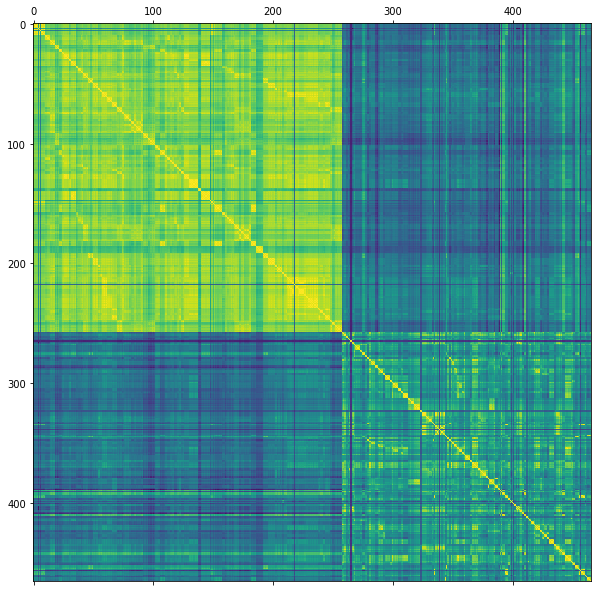

In [273]:
# Скорее всего, много полей состоят из нулей, поэтому такой результат.

plt.figure(figsize=(10,10))
plt.matshow(all_data_corr, fignum=1);

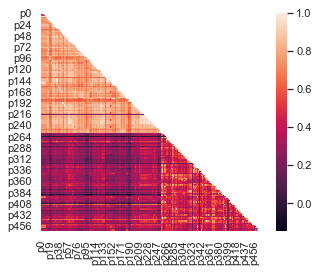

In [298]:
#plt.figure(figsize=(10,10))
mask = np.zeros_like(all_data_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(all_data_corr, mask=mask, vmax=1., square=True)

In [13]:
# Возможен случай, когда коэффициента корреляции нет. Это значит, что в данные поля скорее всего заполнены
# только одним одинаковым значением и их можно опустить при анализе. Проверим.

[i for i in all_data_corr if all_data_corr[i].isnull().drop_duplicates().values[0]]

[]

In [15]:
# Найдем поля, у которых коэффициент корреляции больше заданного значения.

def get_fields_corr(df, corr_val):
    df_corr = df.corr(method='spearman')
    field_corr = []
    for i in df_corr:
        for j in df_corr.index[df_corr[i] > corr_val]:
            if i != j and j not in field_corr and i not in field_corr:
                field_corr.append(j)
                #print('{}-->{}: r^2={}'.format(i, j, action_data_corr[i][action_data_corr.index==j].values[0]))
    return field_corr

In [44]:
# Удаляем эти поля.

all_data_without_corr = all_data.drop(get_fields_corr(all_data, 0.8), axis=1)

In [45]:
all_data_without_corr

,person_id,date,p0,p4,p6,p10,p14,p18,p22,p30,...,p427,p429,p431,p435,p437,p440,p451,p457,p461,p462
0,person_1,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,person_1,2017-06-02,29.0,128.0,2.0,1209.0,470.0,55.0,226.0,83.0,...,165.0,0.0,427.0,0.0,0.0,5.0,26.0,0.0,3.0,0.0
2,person_1,2017-06-03,10.0,34.0,1.0,383.0,406.0,84.0,34.0,102.0,...,41.0,23.0,516.0,0.0,0.0,1.0,12.0,0.0,1.0,2.0
3,person_1,2017-06-04,3.0,40.0,1.0,21.0,2.0,3.0,14.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,person_1,2017-06-05,4.0,62.0,1.0,976.0,805.0,34.0,48.0,42.0,...,392.0,30.0,359.0,0.0,0.0,2.0,8.0,0.0,2.0,2.0
5,person_1,2017-06-06,23.0,0.0,1.0,1926.0,1067.0,23.0,13.0,62.0,...,0.0,0.0,79.0,0.0,0.0,3.0,34.0,0.0,6.0,2.0
6,person_1,2017-06-07,11.0,18.0,0.0,488.0,52.0,38.0,11.0,24.0,...,85.0,0.0,53.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0
7,person_1,2017-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,person_1,2017-06-09,35.0,72.0,1.0,368.0,746.0,81.0,161.0,35.0,...,1315.0,0.0,532.0,1.0,2.0,0.0,21.0,0.0,4.0,1.0
9,person_1,2017-06-10,16.0,30.0,1.0,767.0,221.0,36.0,19.0,75.0,...,83.0,0.0,478.0,0.0,1.0,2.0,13.0,0.0,4.0,1.0


In [14]:
missings_by_column(all_data)

,Missing Count,Missing % of Total
138,347,14.6
90,225,9.5
74,217,9.1
160,183,7.7
100,162,6.8
40,95,4.0
166,62,2.6
190,53,2.2
256,50,2.1
180,47,2.0


In [208]:
missing_values(persons)

person = person_9
     Missing Count  Missing % of Total
138            103                56.3

person = person_5
     Missing Count  Missing % of Total
100             89                48.6
98              26                14.2

person = person_1
     Missing Count  Missing % of Total
138             94                51.4

person = person_2
    Missing Count  Missing % of Total
90            104                56.8
84             23                12.6

person = person_10
     Missing Count  Missing % of Total
138            106                57.9

person = person_6
     Missing Count  Missing % of Total
190             20                10.9

person = person_12
    Missing Count  Missing % of Total
90             90                49.2

person = person_7
     Missing Count  Missing % of Total
160            102                55.7

person = person_8
    Missing Count  Missing % of Total
74             96                52.5
40             65                35.5
16             19

In [255]:
df = all_data.groupby(['person_id']).count().reset_index()

In [257]:
df[feature_labels]

,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
0,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
1,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
2,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
3,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
4,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
5,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
6,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
7,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
8,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
9,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183


In [ ]:
# делаем список всех пользователей

persons = rating_data['person_id'].unique()

In [ ]:
for person in persons:
    

In [165]:
import pandas_profiling

In [91]:
# Заполняем пропуски в данных средним значением по столбцу

def fill_mean(df):
    return df.fillna(df.mean())

In [63]:
df = all_data[all_data['person_id'] == 'person_1']
df.shape[1]

468

In [92]:
#def missing_values
#for person in persons:
df = all_data[all_data['person_id'] == 'person_8']
new = df.fillna(df.mean())

In [143]:
missing_values_by_column(all_data[all_data['person_id'] == 'person_8'])

,Missing Count,Missing % of Total
74,96,52.5
40,65,35.5
16,19,10.4
138,7,3.8
38,7,3.8
44,6,3.3
12,5,2.7
10,1,0.5
14,1,0.5
28,1,0.5


In [164]:
df = all_data.groupby(['person_id']).apply(lambda x: x.isnull().sum())
df[df > 0]

,person_id,date,0,1,2,3,4,5,6,7,...,456,457,458,459,460,461,462,463,464,465
person_id,,,,,,,,,,,,,,,,,,,,,
person_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
result = pd.merge(all_data, rating_data, on='person_id')

In [16]:
result.groupby('person_id').describe()

0                                                         1  \
            count       mean        std  min  25%  50%   75%    max   count   
person_id                                                                     
person_1   4941.0  10.404372  16.160356  0.0  0.0  0.0  17.0   90.0  4941.0   
person_10  4575.0  17.010929  30.389900  0.0  0.0  8.0  22.0  300.0  4575.0   
person_11  4575.0  21.098361  40.588575  0.0  0.0  0.0  31.0  362.0  4575.0   
person_12  9150.0  20.021858  36.823982  0.0  0.0  0.0  25.0  221.0  9150.0   
person_13  4575.0  18.972678  29.098357  0.0  0.0  0.0  34.0  142.0  4575.0   
person_2   9882.0   7.098361  13.673334  0.0  0.0  2.0  10.0  115.0  9882.0   
person_3   4758.0  12.688525  20.944386  0.0  0.0  3.0  20.0  158.0  4758.0   
person_4   4758.0  16.786885  35.381360  0.0  0.0  2.0  20.0  236.0  4758.0   
person_5   4758.0  12.765027  19.030149  0.0  0.0  6.0  18.0  136.0  4758.0   
person_6   4758.0   9.234973  26.813926  0.0  0.0  0.0   4.0  156.0  4758.0   
person_7   9516.0  11.371585  19.610710  0.0  0.0  4.0  14.0  140.0  9516.0   
person_8   4758.0  15.792350  22.390156  0.0  0.0  1.0  28.0  120.0  4758.0   
person_9   4758.0   9.174863  15.290162  0.0  0.0  1.0  10.0   83.0  4758.0   

                    ...        Id         Prediction1                      \
               mean ...       75%     max       count      mean       std   
person_id           ...                                                     
person_1   2.393443 ...     73.00    79.0      4941.0  2.074074  1.358948   
person_10  1.923497 ...    125.00   131.0      4575.0  2.560000  0.852384   
person_11  2.136612 ...    279.00   285.0      4575.0  3.280000  0.664603   
person_12  1.710383 ...   1170.00  1182.0         0.0       NaN       NaN   
person_13  2.349727 ...    304.00   310.0      4575.0  3.360000  1.162194   
person_2   2.295082 ...   1093.00  1106.0         0.0       NaN       NaN   
person_3   2.098361 ...    254.00   260.0      4758.0  2.730769  1.058328   
person_4   2.103825 ...    330.00   336.0      4758.0  3.153846  0.360839   
person_5   2.180328 ...     46.00    52.0      4758.0  3.307692  0.773149   
person_6   1.612022 ...    151.00   157.0      4758.0  4.000000  0.877150   
person_7   2.420765 ...   1195.25  1208.0         0.0       NaN       NaN   
person_8   2.415301 ...    228.00   234.0      4758.0  2.461538  0.929563   
person_9   1.360656 ...     20.00    26.0      4758.0  3.076923  0.266497   

                                    
           min  25%  50%  75%  max  
person_id                           
person_1   1.0  1.0  1.0  4.0  4.0  
person_10  1.0  2.0  3.0  3.0  4.0  
person_11  2.0  3.0  3.0  4.0  4.0  
person_12  NaN  NaN  NaN  NaN  NaN  
person_13  1.0  3.0  3.0  4.0  5.0  
person_2   NaN  NaN  NaN  NaN  NaN  
person_3   1.0  2.0  3.0  3.0  4.0  
person_4   3.0  3.0  3.0  3.0  4.0  
person_5   1.0  3.0  3.0  4.0  5.0  
person_6   2.0  4.0  4.0  5.0  5.0  
person_7   NaN  NaN  NaN  NaN  NaN  
person_8   1.0  2.0  2.0  3.0  4.0  
person_9   3.0  3.0  3.0  3.0  4.0  

[13 rows x 3744 columns]

In [3]:

persons = df_targets['person_id'].unique()

df = df_targets.groupby(['person_id']).count()
known_persons = df.loc[df['Prediction1'] != 0].index.values
unknown_persons = df.loc[df['Prediction1'] == 0].index.values

---

---

In [1]:
# Считаем пропущенные данные по столбцам

def missing_values_by_column(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren = mis_val_table.rename(columns = {0 : 'Missing Count', 1 : '% of Total'})
    mis_val_table_ren = mis_val_table_ren[mis_val_table_ren.iloc[:,1] != 0].sort_values('% of Total', ascending=False).round(1)
    return mis_val_table_ren

In [ ]:
def missing_values_by_row(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren = mis_val_table.rename(columns = {0 : 'Missing Count', 1 : '% of Total'})
    mis_val_table_ren = mis_val_table_ren[mis_val_table_ren.iloc[:,1] != 0].sort_values('% of Total', ascending=False).round(1)
    return mis_val_table_ren

In [6]:
df_missing_known = missing_values_table(df_data[df_data['person_id'].isin(known_persons)])
df_missing_known.head(10)

,Missing,% of Total
138,347,19.0
74,212,11.6
100,161,8.8
40,95,5.2
160,81,4.4
166,62,3.4
256,49,2.7
180,47,2.6
190,44,2.4
98,38,2.1


In [7]:
df_missing_unknown = missing_values_table(df_data[df_data['person_id'].isin(unknown_persons)])
df_missing_unknown.head(10)

,Missing,% of Total
90,195,35.5
160,102,18.6
84,29,5.3
76,15,2.7
88,11,2.0
80,9,1.6
86,9,1.6
190,9,1.6
74,5,0.9
16,4,0.7


In [8]:
# столбцы, в которых много пропущенных значений, может быть стоит убрать из рассмотрения
# остальные значения обнулим

df_data.fillna(0);

In [9]:
# пронормируем фичи
from sklearn.preprocessing import StandardScaler

columns = list(np.arange(df_data.shape[1] - 2))
df_data_scaler = df_data[columns]
scaler = StandardScaler()
df_data_scaler = pd.DataFrame(scaler.fit_transform(df_data_scaler), columns=columns)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
df_data_scaler['person_id'] = df_data['person_id']
df_data_scaler['date'] = df_data['date']

---

In [11]:
# разобьем выборку по временным интервалам между выставлениями оценок для каждого пользователя

# интервалы времени между оценками по пользователю
# возвращаем даты начала и окончания диапазона + Id записи

def get_ranges(data, person):
    ranges = []
    df = data[data['person_id'] == person]
    for idx in range(df.shape[0]):
        start_date = end_date if (idx > 0) else (df.iloc[idx]['date'] - pd.to_timedelta('7 days'))
        end_date = df.iloc[idx]['date']
        ranges.append([start_date, end_date, df.iloc[idx]['Id']])
    return ranges

In [12]:
# данные фич по пользователю за заданный интервал времени
# dates[0] - start date
# dates[1] - end date

def get_range_data(data, person, dates):
    df = data[data['person_id'] == person]
    mask = (df['date'] > dates[0]) & (df['date'] < dates[1])
    return df[mask]

In [229]:
# Усредняем каждую фичу за интервал между выставлениями оценок пользователем

def data_mean(persons, targets, data):
    X = []
    Ids = []
    for person in persons:
        ranges = get_ranges(targets, person)
        for ra in ranges:
            da = get_range_data(data, person, ra)              
            xa = da.mean() if not da.empty else 0
            X.append(xa)
    return [X, Ids]

In [1]:
# взвешиваем каждую фичу за интервал между выставлениями оценок пользователем

def data_weight(persons, targets, data):
    pass

---

In [222]:
# выделим выборки целевых значений

y_true = df_targets[df_targets['person_id'].isin(known_persons)]
y_target = df_targets[df_targets['person_id'].isin(unknown_persons)]

In [223]:
def answer_to_file(predicted, Ids, file_name):
    df_answer = pd.DataFrame(data=Ids, columns=['Id'])
    df_answer['Prediction1'] = predicted
    df_answer.to_csv(file_name, index=False)

---

In [224]:
# Вариант 0. Предсказывать медианное значение по исходной выборке

y_pred = y_true['Prediction1'].quantile(q=0.50) * np.ones(y_target.shape[0])
answer_to_file(y_pred, y_target['Id'].values, 'baseline.csv')

---

In [230]:
# Вариант 1. Усредняем каждую фичу за интервал между выставлениями оценок пользователем. Дальше - используем линейную регрессию

# Добавляем вектор из единиц для коэффициента w0 линейной регрессии.
df_data_scaler['bias'] = 1

X_true = data_mean(known_persons, df_targets, df_data_scaler)
X_target = data_mean(unknown_persons, df_targets, df_data_scaler)

In [226]:
# удаляем оценки, по которым нет предшествующих данных

#y_true = y_true.drop(y_true[y_true['Id'].isin(Ids_true)].index)
#y_target = y_target.drop(y_target[y_target['Id'].isin(Ids_target)].index)

In [241]:
# обнуляем пустые значения фич

X_true = np.array(X_true)
X_true[np.isnan(X_true)] = 0

X_target = np.array(X_target)
X_target[np.isnan(X_target)] = 0

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_true, y_true['Prediction1'].values, test_size=0.2, random_state=42)

---
Linear Regression

In [175]:
from sklearn.linear_model import LinearRegression

In [192]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [193]:
linear_reg.score(X_test, y_test)

-1.4209208003885672

In [194]:
y_pred = linear_reg.predict(X_target)

In [195]:
y_pred.round()

array([ 4.,  4.,  4.,  4.,  3.,  6.,  6.,  3.,  6.,  6.,  4.,  7.,  6.,
        6.,  5.,  9., 10., 10.,  5.,  5.,  4.,  4.,  4.,  4.,  5.,  4.,
        4.,  4.,  3.,  6.,  6.,  3.,  6.,  6.,  4.,  7.,  6.,  6.,  5.,
        9., 10., 10.,  5.,  5.,  4.,  4.,  4.,  4.,  5.,  3.,  5.,  4.,
        4.,  2.,  4.,  1.,  3.,  3.,  6.,  3.,  4.,  4.,  2.,  3.,  4.,
        1.,  6.,  2.,  4.,  2.,  2.,  1.,  3.,  3.,  2.,  2.,  5.,  4.,
        4.,  2.,  4.,  1.,  3.,  3.,  6.,  3.,  4.,  4.,  2.,  3.,  4.,
        1.,  6.,  2.,  4.,  2.,  2.,  1.,  3.,  3.,  2.,  2., 10.,  2.,
        4.,  2.,  3.,  4.,  4.,  7.,  5.,  3.,  0.,  4.,  1.,  2.,  3.,
        2.,  5.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  4.,  4.,  2.,  4.,
        2.,  3.,  4.,  4.,  7.,  5.,  3.,  0.,  4.,  1.,  2.,  3.,  2.,
        5.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,  4.,  4.])

In [74]:
answer_to_file(y_pred, y_target['Id'].values, 'linear_regression.csv')

---
Random Forest Regressor

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [189]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [197]:
forest_reg.score(X_test, y_test)

0.09767736821244544

---
Gradient boosting

In [198]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
boost_reg = ensemble.GradientBoostingRegressor()

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(logistic_reg, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

In [199]:
boost_reg = ensemble.GradientBoostingRegressor()
boost_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [200]:
boost_reg.score(X_test, y_test)

0.042049635747543834

---
Logistic Regression

In [215]:
from sklearn.linear_model import LogisticRegression

In [216]:
logistic_reg = LogisticRegression(solver='saga', multi_class='multinomial')

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(logistic_reg, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1, 2, 3, 4]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [217]:
search.best_params_

{'C': 1, 'penalty': 'l2'}

In [205]:
accuracy_score(y_train, search.best_estimator_.predict(X_train))

0.9170731707317074

In [218]:
logistic_reg = LogisticRegression(C=1, penalty='l2', solver='saga', multi_class='multinomial')
logistic_reg.fit(X_train, y_train)
pred_prob = logistic_reg.predict_proba(X_test)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [219]:
y_pred = logistic_reg.predict(X_target)

In [220]:
answer_to_file(y_pred, y_target['Id'].values, 'logistic_regression.csv')

In [5]:
# есть подозрение, что нужно пронормировать данные, но это не точно

---

In [3]:
# делаем one hot encoding, не знаю, насколько это здесь нужно

In [7]:
for person in persons:
    df_data[person] = pd.Series(data=(df_data['person_id'] == person).astype('float'), index=df_data.index)

features

In [8]:
X_labels = np.delete(df_data.columns.values, [0, 1])

In [9]:
df_X = df_data[df_data['person_id'].isin(known_persons)]
X = df_X[X_labels].values
X[np.isnan(X)] = 0

In [10]:
df_X_target = df_data[df_data['person_id'].isin(target_persons)]
X_target = df_X_target[X_labels].values
X_target[np.isnan(X_target)] = 0

answers

In [11]:
def get_prediction(person, date):
    
    df = df_predictions[df_predictions['person_id'] == person]
    
    for idx in range(df.shape[0]):
        start_date = end_date if (idx > 0) else (df.iloc[idx]['date'] - pd.to_timedelta('7 days'))
        end_date = df.iloc[idx]['date']
        mask = (date > start_date) & (date <= end_date)
        if mask:
            return df.iloc[idx]['Prediction1'] 
    return 0

In [12]:
y = np.zeros(X.shape[0])
y_target = np.zeros(X_target.shape[0])

In [13]:
for idx in range(X.shape[0]):
    y[idx] = get_prediction(df_X.iloc[idx]['person_id'], df_X.iloc[idx]['date'])
    #print('person = {}, date = {}, val = {}'.format(df_X.iloc[idx]['person_id'], df_X.iloc[idx]['date'], y[idx]))

---

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [16]:
clf = LogisticRegression(solver='saga', max_iter=200, multi_class='multinomial')

param_grid = {'C': np.arange(1, 5), 'penalty': ['l1', 'l2']}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(X_train, y_train)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1, 2, 3, 4]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
search.best_params_

{'C': 3, 'penalty': 'l2'}

In [18]:
accuracy_score(y_train, search.best_estimator_.predict(X_train))

0.5635245901639344

In [24]:
optimal_clf = LogisticRegression(C=3, penalty='l2', solver='saga', max_iter=200, multi_class='multinomial')
optimal_clf.fit(X_train, y_train)
pred_prob = optimal_clf.predict_proba(X_test)

C:\Users\yushanov\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [25]:
pred_prob

array([[1.82303191e-03, 3.93654722e-02, 5.55126205e-02, 8.20919688e-01,
        8.01838760e-02, 2.19531131e-03],
       [4.78618194e-03, 8.15590737e-02, 3.25747731e-02, 2.02872916e-02,
        7.94969185e-01, 6.58234950e-02],
       [2.73111315e-04, 8.71674652e-03, 7.01162711e-01, 4.12115116e-02,
        2.46791657e-01, 1.84426270e-03],
       ...,
       [1.28463536e-01, 2.54449341e-02, 1.27131907e-01, 6.32734254e-01,
        5.36400920e-02, 3.25852765e-02],
       [4.08065181e-03, 1.30562908e-02, 6.02840759e-01, 2.14474663e-01,
        1.64015926e-01, 1.53170940e-03],
       [3.79482808e-02, 3.37482089e-01, 1.89276665e-01, 2.04731216e-01,
        1.96347207e-01, 3.42145424e-02]])

---

K-Neighbors Classifier

In [20]:
clf = KNeighborsClassifier()

param_grid = {'weights': ['uniform', 'distance'], 'n_neighbors': np.arange(10, 20), 'metric': ['manhattan', 'euclidean']}

search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'metric': ['manhattan', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [21]:
search.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}

In [22]:
optimal_clf = KNeighborsClassifier(n_neighbors=13, metric='manhattan', weights='distance')
optimal_clf.fit(X_train, y_train)
pred_prob = optimal_clf.predict_proba(X_test)

In [23]:
pred_prob

array([[0.        , 0.        , 0.        , 0.92900969, 0.07099031,
        0.        ],
       [0.07118421, 0.0733502 , 0.        , 0.        , 0.71389433,
        0.14157125],
       [0.        , 0.        , 0.76070257, 0.15971696, 0.07958047,
        0.        ],
       ...,
       [0.15659164, 0.07815148, 0.15334241, 0.53662788, 0.07528658,
        0.        ],
       [0.        , 0.        , 0.46211895, 0.30677005, 0.23111101,
        0.        ],
       [0.159373  , 0.07960921, 0.15239564, 0.3808546 , 0.07592782,
        0.15183974]])

---